In [1]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import random

from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import load_model, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, Concatenate
from keras.optimizers import Adam
import keras

from IPython import display

from helper import *
from visualize import *

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [2]:
raw_vedio_names = ["badboy.mp4","feel_special.mp4","kill_this_love.mp4","somi_birthday.mp4",
    "boombayah_blackpink.mp4","flower_shower.mp4","magnetic_moon_tiffany_young.mp4","sunmi_lalalay.mp4",
    "clc_me.mp4","fromis_9_fun.mp4","mamamoo_hip.mp4","swalla.mp4",
    "dumb_litty.mp4","gfriend_fever.mp4","red_velvet_umpah_umpah.mp4","vav_poison.mp4",
    "everglow_adios.mp4","gi_dle_uh_oh.mp4","red_velvet_zimzalabim.mp4","wjsn_boogie_up.mp4",
    "exid_me_and_you.mp4","jopping.mp4","snapping_chung_ha.mp4"]
vedio_names = []
for raw_vedio_name in raw_vedio_names:
    vedio_names.append(raw_vedio_name.split(".")[0])

In [3]:
def get_position(vedio_name):
    x = np.array(get_frames(vedio_name))
    x_flattened = x.reshape(x.shape[0], -1)
    return x_flattened.astype(np.int64)
sample_x = get_position("badboy")

def get_feature(vedio_name):
    y = np.array(get_feature_np_array(vedio_name))
    return y.astype(np.int64)
sample_y = get_feature("badboy")

print("sample_pos array shape is ", sample_x.shape)
print("sample_feature array shape is ", sample_y.shape)

position_raw = []
feature_raw = []
random.shuffle(vedio_names)
min_input_length = 100000
for vedio_name in vedio_names:
    pos = get_position(vedio_name)
    feature = get_feature(vedio_name)
    # there are corner case that y is one frame longer than x for the different method they use to crop.
    pos = pos[:feature.shape[0], :]
    feature = feature[:pos.shape[0]]
    assert(pos.shape[0] == feature.shape[0])
    if(pos.shape[0] < min_input_length):
        min_input_length = pos.shape[0]
    position_raw.append(pos)
    feature_raw.append(feature)

sample_pos array shape is  (4131, 50)
sample_feature array shape is  (4131, 12)


In [4]:
print("cut all vedio to " + str(min_input_length))
#stack position_raw
position_raw_stacked = np.zeros((len(position_raw), min_input_length, 50))
feature_raw_stacked = np.zeros((len(position_raw), min_input_length, 12))
for i in range(len(position_raw)):
    position_raw_stacked[i, :, :] = position_raw[i][:min_input_length, :].astype(np.float32)
    feature_raw_stacked[i, :, :] = feature_raw[i][:min_input_length, :].astype(np.float32)
print(position_raw_stacked.shape)
print(feature_raw_stacked.shape)

position_raw_stacked = position_raw_stacked[:,:2000:5,:]
feature_raw_stacked = feature_raw_stacked[:,:2000:5,:]

print(position_raw_stacked.shape)
print(feature_raw_stacked.shape)

t_x = position_raw_stacked.shape[1]

cut all vedio to 2023
(23, 2023, 50)
(23, 2023, 12)
(23, 400, 50)
(23, 400, 12)


In [5]:
onehot_map = {}
onehot_map_num_to_pos = {}

num_example = 5
i = 0
position_raw_stacked = position_raw_stacked[:num_example]
feature_raw_stacked = feature_raw_stacked[:num_example]
for sample in position_raw_stacked:
    for pos in sample:
        if(str(pos) not in onehot_map): 
            onehot_map_num_to_pos[i] = pos
            onehot_map[str(pos)] = i
            i = i + 1

num_of_positions = len(onehot_map.values())

In [6]:
position_raw_onehot_stacked = np.zeros((num_example, t_x, num_of_positions))

for i in range(num_example):
    for j in range(t_x):
        k = onehot_map[str(position_raw_stacked[i,j])]
        position_raw_onehot_stacked[i][j][k] = 1

In [7]:
# Append prev position with feature and make X and Y both (, , 62)
shape_0 = position_raw_onehot_stacked.shape[0]
shape_1 = position_raw_onehot_stacked.shape[1]
X = np.zeros((shape_0, shape_1 ,num_of_positions + 12))
Y = np.zeros((shape_0, shape_1 , num_of_positions + 12))

Y[:, 0, :] = np.concatenate([feature_raw_stacked[:, 0, :], position_raw_onehot_stacked[:, 0, :]], axis=-1)
t = 1
for t in range(shape_1):
    X[:, t, :] = np.concatenate([feature_raw_stacked[:, t, :], position_raw_onehot_stacked[:, t - 1, :]], axis=-1)
    Y[:, t, :] = np.concatenate([feature_raw_stacked[:, t, :], position_raw_onehot_stacked[:, t, :]], axis=-1)
    
# swap axis 0 and 1 for Y
Y = np.reshape(Y, (shape_1, shape_0, num_of_positions + 12))
print(X.shape)
print(Y.shape)

(5, 400, 2012)
(400, 5, 2012)


In [8]:
LSTM_cell = LSTM(64, return_state = True) 
densor = Dense(num_of_positions, activation='softmax')

In [9]:
def djmodel(Tx, n_a, n_values):
    X = Input(shape=(Tx, n_values))

    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0

    outputs = []
    
    for t in range(Tx):
        x = Lambda(lambda x: x[:,t,:])(X)
        x = Reshape((1, n_values))(x) 
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        out = densor(a)
        outputs.append(out)
        
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    return model

In [10]:
model = djmodel(Tx = t_x , n_a = 64, n_values = num_of_positions + 12)

In [11]:
opt = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy')

In [12]:
a0 = np.zeros((num_example, 64))
c0 = np.zeros((num_example, 64))

In [13]:
Y = np.reshape(position_raw_onehot_stacked, (shape_1, shape_0, num_of_positions))
history = model.fit([X, a0, c0], list(Y), epochs=100)

Epoch 1/100
5/5 [==============================] - 773s 155s/step - loss: 3040.3423 - dense_1_loss: 7.6007
Epoch 2/100
5/5 [==============================] - 1s 243ms/step - loss: 3006.6895 - dense_1_loss: 7.4760
Epoch 3/100
5/5 [==============================] - 1s 239ms/step - loss: 2916.9604 - dense_1_loss: 7.5279
Epoch 4/100
5/5 [==============================] - 1s 238ms/step - loss: 2670.9539 - dense_1_loss: 6.2499
Epoch 5/100
5/5 [==============================] - 1s 244ms/step - loss: 2555.8020 - dense_1_loss: 5.6832
Epoch 6/100
5/5 [==============================] - 1s 241ms/step - loss: 2188.0188 - dense_1_loss: 4.5549
Epoch 7/100
5/5 [==============================] - 1s 250ms/step - loss: 1796.7651 - dense_1_loss: 3.1213
Epoch 8/100
5/5 [==============================] - 1s 240ms/step - loss: 1369.6573 - dense_1_loss: 1.9819
Epoch 9/100
5/5 [==============================] - 1s 238ms/step - loss: 999.0261 - dense_1_loss: 1.0851
Epoch 10/100
5/5 [============================

5/5 [==============================] - 1s 243ms/step - loss: 97.9752 - dense_1_loss: 0.0066
Epoch 79/100
5/5 [==============================] - 1s 238ms/step - loss: 96.5166 - dense_1_loss: 0.0063
Epoch 80/100
5/5 [==============================] - 1s 238ms/step - loss: 95.1845 - dense_1_loss: 0.0060
Epoch 81/100
5/5 [==============================] - 1s 237ms/step - loss: 93.9608 - dense_1_loss: 0.0057
Epoch 82/100
5/5 [==============================] - 1s 231ms/step - loss: 92.8291 - dense_1_loss: 0.0055
Epoch 83/100
5/5 [==============================] - 1s 239ms/step - loss: 91.7831 - dense_1_loss: 0.0052
Epoch 84/100
5/5 [==============================] - 1s 240ms/step - loss: 90.8239 - dense_1_loss: 0.0050
Epoch 85/100
5/5 [==============================] - 1s 241ms/step - loss: 89.9524 - dense_1_loss: 0.0048
Epoch 86/100
5/5 [==============================] - 1s 236ms/step - loss: 89.1625 - dense_1_loss: 0.0046
Epoch 87/100
5/5 [==============================] - 1s 235ms/step - 

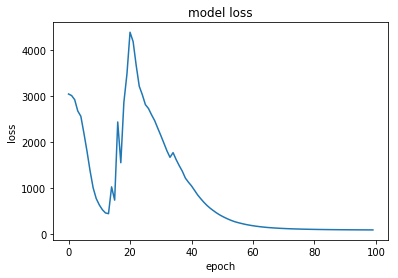

In [14]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [15]:
def music_inference_model(LSTM_cell, densor, Tx, n_values, n_a = 64):
    X = Input(shape=(Tx, n_values))

    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = Lambda(lambda x: x[:,0,12:])(X)

    outputs = []

    for t in range(Tx):
        pred_postion = Lambda(lambda x: x[:,:])(x)
        cur_feature = Lambda(lambda x: x[:,t,:12])(X)
        x = Concatenate(axis=1)([cur_feature, pred_postion])
        x = Reshape((1, n_values))(x)
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        out = densor(a)
        outputs.append(out)
        x = out

    inference_model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    return inference_model

In [16]:
inference_model = music_inference_model(LSTM_cell, densor, Tx = t_x, n_values = num_of_positions + 12, n_a = 64)

In [31]:
a_initializer = np.zeros((1, 64))
c_initializer = np.zeros((1, 64))

In [32]:
pred_X = np.concatenate((feature_raw_stacked[0], position_raw_onehot_stacked[0]), axis = 1)
pred_X = np.reshape(pred_X, (1, t_x, num_of_positions + 12))
print(pred_X.shape)

(1, 400, 2012)


In [33]:
pred = inference_model.predict([pred_X, a_initializer, c_initializer])

In [34]:
output_onehot = np.array(pred)[:,0,:]
print(np.sum(output_onehot))
output_ind = np.argmax(output_onehot, axis=1)

output_position = np.zeros((t_x, 50))

for j in range(t_x):
    output_position[j] = onehot_map_num_to_pos[int(output_ind[j])]
output_position = np.reshape(output_position, (output_position.shape[0], 25, 2))

400.0


input_images[0] 360
input_images[0][0] 640


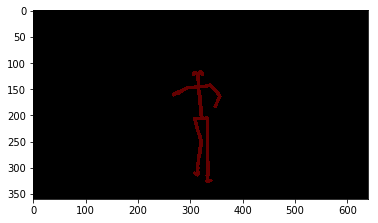

In [35]:
vectors_to_video(output_position,output_path='/home/ubuntu/dance-to-beats/src/model/output_seq_gen.avi',
                 frame_size=(640,360),begin_frame=0,end_frame=199)


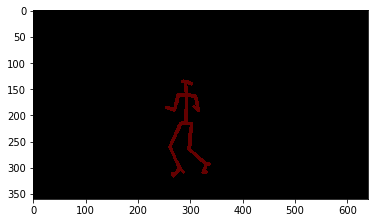

In [30]:
output_position1 = output_position
plt.imshow(draw_one_frame(output_position[3]))


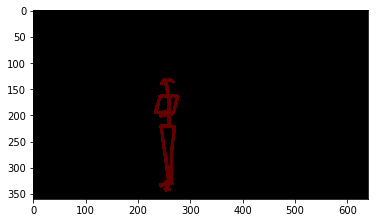

In [23]:
output_position2 = output_position
plt.imshow(draw_one_frame(output_position[6]))

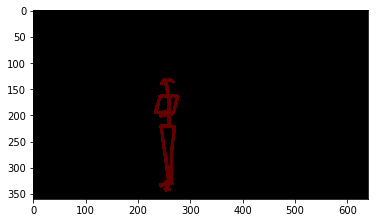

In [24]:
output_position3 = output_position
plt.imshow(draw_one_frame(output_position[6]))

In [25]:
np.sum(output_position1 - output_position2)

0.0